# Imports

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
import matplotlib.pyplot as plt
import time 
import numpy as np
import torch
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import datetime
from scipy.interpolate import interp1d
import pandas as pd
import scipy
from scipy import signal
from scipy.interpolate import CubicSpline
import random
import math
import csv
from scipy.signal import butter, lfilter
from scipy.signal import freqz


Mounted at /content/gdrive


# Helpfull functions

In [3]:
def subpixel_reshuffle_1D_impl(X, m):    
    """
    x shape  =  [10,500]
    retrun shape [5 1000]
    """
    # return torch.transpose(torch.stack([torch.reshape(x,(-1,)) for x in torch.split(X,m,dim = 0)]),-2,-1)   
    return torch.stack([torch.reshape(x,(-1,)) for x in torch.split(torch.transpose(X,0,1),m,dim = 1)])
1
def subpixel_reshuffle_1D(X, m, name=None):
    """
    Reduce number of channels by m
    Example:
    x = randn(100,10,500)% C = 10 channels,L = 500
    y = subpixel_reshuffle_1D(x,2)
    y.shape == [100,5,1000]
    """
    verbose = False
    result = torch.zeros(X.shape[0],int(X.shape[1]/m),int(X.shape[2]*m))
    if verbose:
      print("shape of input is {}".format(X.shape))
      print("shape of result is {}".format(result.shape))
    for i in range(X.shape[0]):
      if verbose:
        print("shape of func subpixel reshuffle is {}".format(subpixel_reshuffle_1D_impl(X[i,:,:],m).shape))
      result[i,:,:] = subpixel_reshuffle_1D_impl(X[i,:,:],m)
    return result



def pixel_shuffle_1d(input, upscale_factor):
    input_size = list(input.size())
    dimensionality = len(input_size) - 2
    input_size[1] //= (upscale_factor ** dimensionality)
    output_size = [dim * upscale_factor for dim in input_size[2:]]  
    input_view = input.contiguous().view(
        input_size[0], input_size[1],
        *(([upscale_factor] * dimensionality) + input_size[2:])
    )

    indicies = list(range(2, 2 + 2 * dimensionality))    
    indicies = indicies[1::2] + indicies[0::2]
    shuffle_out = input_view.permute(0, 1, *(indicies[::-1])).contiguous()
    return shuffle_out.view(input_size[0], input_size[1], *output_size)    



def pad_with_zeros2fit_net(input):
    number_of_zeros_needed = 128 - input.shape[1]%128
    zeros2pad              = torch.zeros(input.shape[0],number_of_zeros_needed)
    Padded_data            = torch.cat((input,zeros2pad),dim = 1)
    return Padded_data


def plot_it(train, validation):
  plt.plot(np.arange(1, train.__len__() + 1), train)
  plt.plot(np.arange(1, train.__len__() + 1), validation)
  plt.legend(('Train ', 'Val '), loc='upper right')
  plt.ylabel('MSE')
  plt.xlabel('Epoch #')
  plt.title("Training and Validation Learning Curve")
  plt.grid()
  plt.show()


def ModelEvaluate(Validation,Ground_truth):
    Bats_net.eval()                                                                          # No DropOut 
    total_loss = 0      
    # idx = np.random.randint(0,Validation.__len__() - 1,1)
    with torch.no_grad():
      for i, data in enumerate(Validation, 0):  
        output = Bats_net(Validation[i])                                            # forward pass
        total_loss += criterion(output[1], Ground_truth[i].double())
        # print(total_loss)
        # print(type(total_loss))
    return total_loss/i 

def plot_it_time_domain(x, t,title):
  plt.figure()
  plt.plot(t, x)
  plt.ylabel('[v]')
  plt.xlabel('t[s]')
  plt.title(title)
  plt.grid()
  plt.show()    

def PCA_The_Data(x):
  M     = x - torch.mean(x,0)
  print(M.shape)
  cov_M = torch.matmul(torch.transpose(M,1,0),M)/(M.shape[0])
  print(cov_M.shape)
  (U, S, V) = torch.pca_lowrank(cov_M,(M.shape[1]))
  print(U.shape)
  print(S.shape)
  print(V.shape)
  data_after_pca = torch.matmul(x,U) 
  return data_after_pca,V

# Load Data and preprocess

Detailed preprocess
1.
2.
3.
...

In [19]:
Batch_size = 5
Val_size   = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  ## use cuda
mode = 2     #0 - Upsample, 1 - clipped, 2 - Up sample Clipped signals
Clipped_val = 0.3
init_lr = 1e-2
lr_dec_factor = 0.97
path = "/content/gdrive/MyDrive/DeepLearning/project_308261163_316128727/Matlab/ResultsSimulation1001.csv"
## Fetch high resolution (sampled in 250Khz) Data From computer
from google.colab import files
df = pd.read_csv(path)
Data = torch.tensor(df.values,dtype=torch.double)
print(Data.shape)
if not mode:#if Upsample
  print("UpSampling mode")
  ## Decimate to 100Khz signals
  Data_decimated = scipy.signal.resample_poly(Data,2,5,axis = 1)

  ## Cubic interpoulate tham back to 250Khz
  x = torch.arange(Data_decimated.shape[1])
  x_interp = torch.linspace(0,Data_decimated.shape[1] -1,Data.shape[1] -2)
  Data_Interp = torch.tensor(CubicSpline(x, Data_decimated,axis = 1)(x_interp))

  ## zero pad to meet net requirement multiple of 128

  Data2Batch              = pad_with_zeros2fit_net(Data_Interp)
  Data_ground_truth2Batch = pad_with_zeros2fit_net(Data)

  ## Split to batches of (Cubic interp signals,Ground truth/High reolution)
  #   Input to Deep net in batches = Cubic interp signals
  #   Ground_truth in batches =  Signals/High reolution
  Data_in_batches                 = list(torch.split(Data2Batch,Batch_size))
  Ground_truth_batches            = list(torch.split(Data_ground_truth2Batch,Batch_size))
  Data_in_batches                 = [torch.unsqueeze(sample,dim = 1) for sample in Data_in_batches]
  Ground_truth_batches            = [torch.unsqueeze(sample,dim = 1) for sample in Ground_truth_batches]
  Train_data                      = Data_in_batches[0:math.ceil(Data_in_batches.__len__() * (1- Val_size))]
  Validation_data                 = Data_in_batches[math.ceil(Data_in_batches.__len__() * (1- Val_size)):]
  Train_Ground_Truth              = Ground_truth_batches[0:math.ceil(Ground_truth_batches.__len__() * (1- Val_size))]
  Validation_Ground_Truth         = Ground_truth_batches[math.ceil(Ground_truth_batches.__len__() * (1- Val_size)):]
  number_of_validation_batches    = Validation_data.__len__()
  print("size of Training data batch is {} number of batches is {}".format(Train_data[1].shape,Train_data.__len__()))
  print("size of Validation data batch is {} number of batches is {}".format(Validation_data[1].shape,Validation_data.__len__()))
elif mode == 1:#if Clipping
  print("Restoring Clipped signal")
  print("minimum of data before clipping is {}".format(torch.min(Data)))
  print("maximum of data before clipping is {}".format(torch.max(Data)))
  Clipped_Data = torch.clip(Data,-Clipped_val,Clipped_val)
  print("minimum of data after clipping is {}".format(torch.min(Clipped_Data)))
  print("maximum of data after clipping is {}".format(torch.max(Clipped_Data)))
    ## zero pad to meet net requirement multiple of 128
  
  Data2Batch              = pad_with_zeros2fit_net(Clipped_Data)
  Data_ground_truth2Batch = pad_with_zeros2fit_net(Data)

  ## Split to batches of (Clipped signals,Ground truth/High reolution)
  #   Input to Deep net in batches = Clipped signals
  #   Ground_truth in batches =  Signals/High reolution
  Data_in_batches                 = list(torch.split(Data2Batch,Batch_size))
  Ground_truth_batches            = list(torch.split(Data_ground_truth2Batch,Batch_size))
  Data_in_batches                 = [torch.unsqueeze(sample,dim = 1) for sample in Data_in_batches]
  Ground_truth_batches            = [torch.unsqueeze(sample,dim = 1) for sample in Ground_truth_batches]
  Train_data                      = Data_in_batches[0:math.ceil(Data_in_batches.__len__() * (1- Val_size))]
  Validation_data                 = Data_in_batches[math.ceil(Data_in_batches.__len__() * (1- Val_size)):]
  Train_Ground_Truth              = Ground_truth_batches[0:math.ceil(Ground_truth_batches.__len__() * (1- Val_size))]
  Validation_Ground_Truth         = Ground_truth_batches[math.ceil(Ground_truth_batches.__len__() * (1- Val_size)):]
  number_of_validation_batches    = Validation_data.__len__()
  print("size of Training data batch is {} number of batches is {}".format(Train_data[1].shape,Train_data.__len__()))
  print("size of Validation data batch is {} number of batches is {}".format(Validation_data[1].shape,Validation_data.__len__()))



elif mode == 2:#upsample clipped signals
  print("Upsampling and Restoring Clipped signal")
  print("minimum of data before clipping is {}".format(torch.min(Data)))
  print("maximum of data before clipping is {}".format(torch.max(Data)))
  Clipped_Data = torch.clip(Data,-Clipped_val,Clipped_val)
  print("minimum of data after clipping is {}".format(torch.min(Clipped_Data)))
  print("maximum of data after clipping is {}".format(torch.max(Clipped_Data)))

  ## Decimate to 100Khz signals
  Data_decimated = scipy.signal.resample_poly(Clipped_Data,2,5,axis = 1)

  ## Cubic interpoulate tham back to 250Khz
  x = torch.arange(Data_decimated.shape[1])
  x_interp = torch.linspace(0,Data_decimated.shape[1] -1,Data.shape[1] -2)
  Data_Interp = torch.tensor(CubicSpline(x, Data_decimated,axis = 1)(x_interp))

  ## zero pad to meet net requirement multiple of 128

  Data2Batch              = pad_with_zeros2fit_net(Data_Interp)
  Data_ground_truth2Batch = pad_with_zeros2fit_net(Data)

  ## Split to batches of (Cubic interp signals,Ground truth/High reolution)
  #   Input to Deep net in batches = Cubic interp signals
  #   Ground_truth in batches =  Signals/High reolution
  Data_in_batches                 = list(torch.split(Data2Batch,Batch_size))
  Ground_truth_batches            = list(torch.split(Data_ground_truth2Batch,Batch_size))
  Data_in_batches                 = [torch.unsqueeze(sample,dim = 1) for sample in Data_in_batches]
  Ground_truth_batches            = [torch.unsqueeze(sample,dim = 1) for sample in Ground_truth_batches]
  Train_data                      = Data_in_batches[0:math.ceil(Data_in_batches.__len__() * (1- Val_size))]
  Validation_data                 = Data_in_batches[math.ceil(Data_in_batches.__len__() * (1- Val_size)):]
  Train_Ground_Truth              = Ground_truth_batches[0:math.ceil(Ground_truth_batches.__len__() * (1- Val_size))]
  Validation_Ground_Truth         = Ground_truth_batches[math.ceil(Ground_truth_batches.__len__() * (1- Val_size)):]
  number_of_validation_batches    = Validation_data.__len__()
  print("size of Training data batch is {} number of batches is {}".format(Train_data[1].shape,Train_data.__len__()))
  print("size of Validation data batch is {} number of batches is {}".format(Validation_data[1].shape,Validation_data.__len__()))

torch.Size([1000, 3751])
Upsampling and Restoring Clipped signal
minimum of data before clipping is -1.0272
maximum of data before clipping is 1.0327
minimum of data after clipping is -0.3
maximum of data after clipping is 0.3
size of Training data batch is torch.Size([5, 1, 3840]) number of batches is 180
size of Validation data batch is torch.Size([5, 1, 3840]) number of batches is 20




# Model Construction

In [20]:
class Bats_Up_Sampler(nn.Module):
# Input shape is [Batch Size(32),Sample Size(1408),Channels(1)]
  def __init__(self, input_shape,
                          number_of_downsample_layers=8,
                          channel_multiple=8,
                          initial_filter_window=5,
                          initial_stride=2,
                          downsample_filter_window=3,
                          downsample_stride=2,
                          bottleneck_filter_window=4,
                          bottleneck_stride=2,
                          upsample_filter_window=3):
  
    super(Bats_Up_Sampler,self).__init__()
    #DownSample Layers
    self.first_down_sample                    = nn.Sequential(nn.Conv1d(input_shape[1],channel_multiple*input_shape[1],initial_filter_window,initial_stride,padding  = 2),
                                                              nn.BatchNorm1d(channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.second_down_sample                    = nn.Sequential(nn.Conv1d(channel_multiple*input_shape[1],2*channel_multiple*input_shape[1],downsample_filter_window,initial_stride,padding  = 1),
                                                              nn.BatchNorm1d(2*channel_multiple*input_shape[1]),
                                                              nn.ReLU())   
    self.third_down_sample                    = nn.Sequential(nn.Conv1d(2*channel_multiple*input_shape[1],4*channel_multiple*input_shape[1],downsample_filter_window,initial_stride,padding  = 1),
                                                              nn.BatchNorm1d(4*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.forth_down_sample                    = nn.Sequential(nn.Conv1d(4*channel_multiple*input_shape[1],8*channel_multiple*input_shape[1],downsample_filter_window,initial_stride,padding  = 1),
                                                              nn.BatchNorm1d(8*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.fifth_down_sample                    = nn.Sequential(nn.Conv1d(8*channel_multiple*input_shape[1],16*channel_multiple*input_shape[1],downsample_filter_window,initial_stride,padding  = 1),
                                                              nn.BatchNorm1d(16*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    
    # Bottle Neck
    self.bottle_neck                          = nn.Sequential(nn.Conv1d(16*channel_multiple*input_shape[1],32*channel_multiple*input_shape[1],bottleneck_filter_window,bottleneck_stride,padding  = 1),
                                                              nn.BatchNorm1d(32*channel_multiple*input_shape[1]),
                                                              nn.ReLU())      #Risidual is taking cared of in forward pass
    # # Bottle Neck
    # self.bottle_neck                          = nn.Sequential(nn.Conv1d(8*channel_multiple*input_shape[1],16*channel_multiple*input_shape[1],bottleneck_filter_window,bottleneck_stride,padding  = 1),
    #                                                           nn.BatchNorm1d(16*channel_multiple*input_shape[1]),
    #                                                           nn.ReLU())      #Risidual is taking cared of in forward pass
    
        
    
    #UpSample Layers
    self.fifth_up_sample_block            = nn.Sequential(nn.Conv1d(32*channel_multiple*input_shape[1],16*channel_multiple*input_shape[1],upsample_filter_window,padding  = 1),
                                                              nn.BatchNorm1d(16*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    

    #UpSample Layers
    self.forth_up_sample_block            = nn.Sequential(nn.Conv1d(16*channel_multiple*input_shape[1],8*channel_multiple*input_shape[1],upsample_filter_window,padding  = 1),
                                                              nn.BatchNorm1d(8*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.third_up_sample_block           = nn.Sequential(nn.Conv1d(8*channel_multiple*input_shape[1],4*channel_multiple*input_shape[1],upsample_filter_window,padding  = 1),
                                                              nn.BatchNorm1d(4*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.second_up_sample_block            = nn.Sequential(nn.Conv1d(4*channel_multiple*input_shape[1],2*channel_multiple*input_shape[1],upsample_filter_window,padding  = 1),
                                                              nn.BatchNorm1d(2*channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.first_up_sample_block            = nn.Sequential(nn.Conv1d(2*channel_multiple*input_shape[1],channel_multiple*input_shape[1],upsample_filter_window,padding  = 1),
                                                              nn.BatchNorm1d(channel_multiple*input_shape[1]),
                                                              nn.ReLU())
    self.final_conv =                     nn.Sequential(nn.Conv1d(channel_multiple*input_shape[1],2,upsample_filter_window,padding  = 1),
                                                              nn.ELU())
    
    
    
    # SubPixel Restack Conv Add



  def forward(self,input):
    verbose = False
    ## Down Sampling
    D1                   = self.first_down_sample(input)
    D2                   = self.second_down_sample(D1)
    D3                   = self.third_down_sample(D2)
    D4                   = self.forth_down_sample(D3)
    D5                   = self.fifth_down_sample(D4)
    if verbose:
      print(" D1 shape is {}\n D2 shape is {}\n D3 shape is {}\n D4 shape is {}".format(D1.shape,D2.shape,D3.shape,D4.shape))
    ## Bottle Neck
    BN                   = self.bottle_neck(D5)
    if verbose:
      print(" BN shape is {}".format(BN.shape))
    ##Up sampling
    U5_up_sample                  = self.fifth_up_sample_block(BN)
    U5_up_sample_pixel_shuffled   = subpixel_reshuffle_1D(U5_up_sample,2)
    U5_res                        = torch.narrow(D5,1,0,U5_up_sample_pixel_shuffled.shape[1])
    U5                            = torch.cat((U5_res,U5_up_sample_pixel_shuffled),dim = 1)
    if verbose:
      print(" U5_up_sample shape is {}\n U5_up_sample_pixel_shuffled shape is {}\n U5_res shape is {}\n U5 shape is {}\n".format(U5_up_sample.shape,U5_up_sample_pixel_shuffled.shape,U5_res.shape,U5.shape))
    
    U4_up_sample                  = self.forth_up_sample_block(U5)
    U4_up_sample_pixel_shuffled   = subpixel_reshuffle_1D(U4_up_sample,2)
    U4_res                        = torch.narrow(D4,1,0,U4_up_sample_pixel_shuffled.shape[1])
    U4                            = torch.cat((U4_res,U4_up_sample_pixel_shuffled),dim = 1)
    if verbose:
      print(" U4_up_sample shape is {}\n U4_up_sample_pixel_shuffled shape is {}\n U4_res shape is {}\n U4 shape is {}\n".format(U4_up_sample.shape,U4_up_sample_pixel_shuffled.shape,U4_res.shape,U4.shape))
    U3_up_sample                  = self.third_up_sample_block(U4)
    U3_up_sample_pixel_shuffled   = pixel_shuffle_1d(U3_up_sample,2)
    U3_res                        = torch.narrow(D3,1,0,U3_up_sample_pixel_shuffled.shape[1])
    U3                            = torch.cat((U3_res,U3_up_sample_pixel_shuffled),dim = 1)
    if verbose:
      print(" U3_up_sample shape is {}\n U3_up_sample_pixel_shuffled shape is {}\n U3_res shape is {}\n U3 shape is {}\n".format(U3_up_sample.shape,U3_up_sample_pixel_shuffled.shape,U3_res.shape,U3.shape))
    U2_up_sample                  = self.second_up_sample_block(U3)
    U2_up_sample_pixel_shuffled   = pixel_shuffle_1d(U2_up_sample,2)
    U2_res                        = torch.narrow(D2,1,0,U2_up_sample_pixel_shuffled.shape[1])
    U2                            = torch.cat((U2_res,U2_up_sample_pixel_shuffled),dim = 1)    
    if verbose:
      print(" U2_up_sample shape is {}\n U2_up_sample_pixel_shuffled shape is {}\n U2_res shape is {}\n U2 shape is {}\n".format(U2_up_sample.shape,U2_up_sample_pixel_shuffled.shape,U2_res.shape,U2.shape))

    U1_up_sample                  = self.first_up_sample_block(U2)
    U1_up_sample_pixel_shuffled   = pixel_shuffle_1d(U1_up_sample,2)
    U1_res                        = torch.narrow(D1,1,0,U1_up_sample_pixel_shuffled.shape[1])
    U1                            = torch.cat((U1_res,U1_up_sample_pixel_shuffled),dim = 1)
    if verbose:
      print(" U1_up_sample shape is {}\n U1_up_sample_pixel_shuffled shape is {}\n U1_res shape is {}\n U1 shape is {}\n".format(U1_up_sample.shape,U1_up_sample_pixel_shuffled.shape,U1_res.shape,U1.shape))

    # target_size     = int(input.shape[2]/2)
    # restack         = subpixel_restack(U1,target_size + (3 - 1))
    conv            = self.final_conv(U1)
    y_before_add    = subpixel_reshuffle_1D(conv,2)
    y               = torch.add(y_before_add,input)
    if verbose:
      print(" conv shape is {}\n y_before_add shape is {}\n y shape is {}\n".format(conv.shape,y_before_add.shape,y.shape))

    
    return input,y
criterion = nn.MSELoss().double()

# Model Training

Epoch number is 1, Training Loss for is 0.0421, Validation Loss is 0.0270, lr is 0.01000
Epoch number is 2, Training Loss for is 0.0203, Validation Loss is 0.0212, lr is 0.00970
Epoch number is 3, Training Loss for is 0.0180, Validation Loss is 0.0194, lr is 0.00941
Epoch number is 4, Training Loss for is 0.0172, Validation Loss is 0.0190, lr is 0.00913
Epoch number is 5, Training Loss for is 0.0168, Validation Loss is 0.0177, lr is 0.00885
Epoch number is 6, Training Loss for is 0.0164, Validation Loss is 0.0171, lr is 0.00859
Epoch number is 7, Training Loss for is 0.0163, Validation Loss is 0.0170, lr is 0.00833
Epoch number is 8, Training Loss for is 0.0161, Validation Loss is 0.0168, lr is 0.00808
Epoch number is 9, Training Loss for is 0.0158, Validation Loss is 0.0164, lr is 0.00784
Epoch number is 10, Training Loss for is 0.0156, Validation Loss is 0.0163, lr is 0.00760
Epoch number is 11, Training Loss for is 0.0155, Validation Loss is 0.0163, lr is 0.00737
Epoch number is 12,

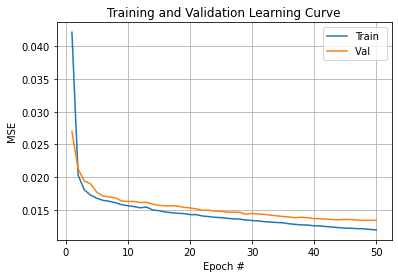

In [21]:
Start_time            = "{}".format(datetime.datetime.now())
Bats_net              = Bats_Up_Sampler(Train_data[0].shape).double()
# optimizer_net         = optim.Adam(Bats_net.parameters(), lr = init_lr)
optimizer_net         = optim.Adam(Bats_net.parameters(), lr = init_lr,weight_decay = 1e-5)
Training_loss         = []
Validation_loss       = []

for epoch in range(50):  # loop over the dataset multiple times, every epoch
  running_loss = 0.0
  Bats_net.train()
  for i, data in enumerate(Train_data, 0):
      # zero the parameter gradients
      optimizer_net.zero_grad()
      # forward + backward + optimize
      # print(data.shape)
      outputs = Bats_net(data.double())
      # print(outputs[1].shape)
      # print(Ground_truth_batches[1].shape)
      loss_net = criterion(outputs[1], Ground_truth_batches[i].double())
      loss_net.backward()
      optimizer_net.step()
      # print statistics
      running_loss += loss_net.item()
  Training_loss.append(running_loss/i)
  Validation_loss.append(ModelEvaluate(Validation_data,Validation_Ground_Truth))
  print("Epoch number is {}, Training Loss for is {:0.4f}, Validation Loss is {:0.4f}, lr is {:0.5f}".format(epoch + 1 , Training_loss[epoch],Validation_loss[epoch],init_lr*lr_dec_factor**epoch))
  # if epoch <= 20:
  for g in optimizer_net.param_groups:    ##decay learning rate between epochs
    g['lr'] *= lr_dec_factor
plot_it(Training_loss, Validation_loss)




# Presantation

Down sample and clipped signal retore


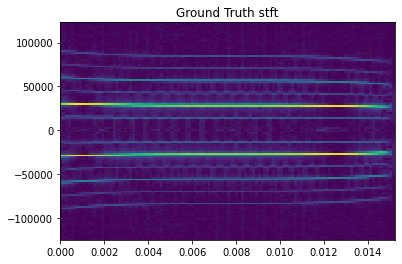

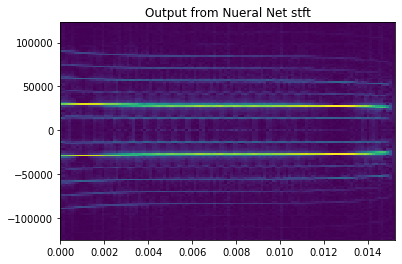

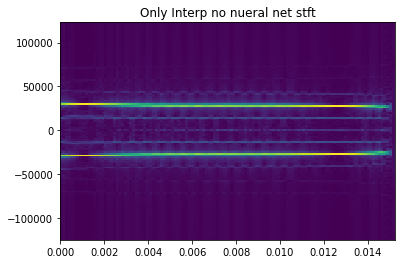

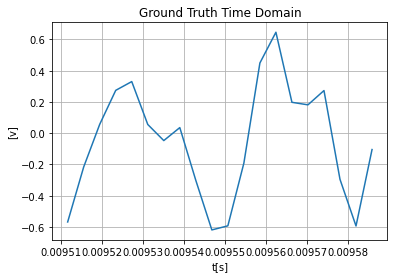

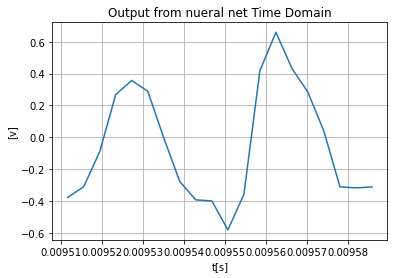

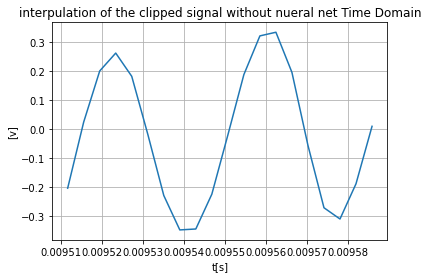

MSE loss between ground truth and interpulation of the clipped signal without nueral net is 0.0711438914825153
MSE loss between ground truth and nueral net output is 0.026631477270879653
SNR interp 24.183021284223237
SNR net 27.51777744931825
LSD interp 8.343537377387674
LSD net 4.462034384440629


In [22]:
if not mode:#if Upsample
  Bats_net.eval()
  with torch.no_grad():
    idx_batch         = np.random.randint(0,Validation_Ground_Truth.__len__() - 1,1)     # Choose random batch
    idx_signal        = np.random.randint(0,Batch_size - 2,1)     # Choose random batch
    # ground_truth      = torch.squeeze(Ground_truth_batches[idx_batch[0]][idx_signal[0]],dim = 0)
    ground_truth      = Ground_truth_batches[idx_batch[0]][idx_signal[0]]
    data2net          = Validation_data[idx_batch[0]]
    output_from_net   = Bats_net(data2net)[1]
    # output            = torch.squeeze(output_from_net[idx_signal[0]],dim = 0)
    output            = output_from_net[idx_signal[0]]
    nfft              = 128#output.shape[1]
    # print(ground_truth.shape)
    ground_truth_stft         = torch.roll(torch.stft(ground_truth,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    output_stft               = torch.roll(torch.stft(output,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    no_nueral_net_only_interp = torch.roll(torch.stft(data2net[idx_signal[0]],nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    f                 = np.arange(-nfft/2,nfft/2) * 250000/nfft
    # print(ground_truth_stft.shape)
    t                 = np.arange(0,ground_truth_stft.shape[2]) * ground_truth.shape[1]/(250000*ground_truth_stft.shape[2])

    print("Down sample signal retore")
    plt.figure()
    plt.pcolormesh(t,f, torch.abs(torch.squeeze(ground_truth_stft,dim = 0)))
    plt.title("Ground Truth stft")
    plt.figure()
    plt.pcolormesh(t,f,torch.abs(torch.squeeze(output_stft,dim = 0)))
    plt.title("Output from Nueral Net stft")
    plt.figure()
    plt.pcolormesh(t,f,torch.abs(torch.squeeze(no_nueral_net_only_interp,dim = 0)))
    plt.title("Only Interp no nueral net stft")
    t                 = np.arange(0,ground_truth.shape[1]) * 0.015/(ground_truth.shape[1])
    idx_time = np.random.randint(0,ground_truth.shape[1] - 30)
    plot_it_time_domain(ground_truth[0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Ground Truth Time Domain")
    plot_it_time_domain(output[0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Output from nueral net Time Domain")
    plot_it_time_domain(data2net[idx_signal[0]][0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Only Interp no nueral net Time Domain")
    print("MSE loss between ground truth and interpulation without nueral net is {}".format(criterion(ground_truth,data2net[idx_signal[0]]).item()))
    print("MSE loss between ground truth and nueral net output is {}".format(criterion(ground_truth,output).item()))
    interp = no_nueral_net_only_interp
elif mode == 1:#if Clipping
  Bats_net.eval()
  with torch.no_grad():
    idx_batch         = np.random.randint(0,Validation_Ground_Truth.__len__() - 1,1)     # Choose random batch
    idx_signal        = np.random.randint(0,Batch_size - 2,1)     # Choose random batch
    # ground_truth      = torch.squeeze(Ground_truth_batches[idx_batch[0]][idx_signal[0]],dim = 0)
    ground_truth      = Validation_Ground_Truth[idx_batch[0]][idx_signal[0]]
    data2net          = Validation_data[idx_batch[0]]
    output_from_net   = Bats_net(data2net)[1]
    # output            = torch.squeeze(output_from_net[idx_signal[0]],dim = 0)
    output            = output_from_net[idx_signal[0]]
    nfft              = 128#output.shape[1]
    # print(ground_truth[0])
    ground_truth_stft         = torch.roll(torch.stft(ground_truth,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    output_stft               = torch.roll(torch.stft(output,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    no_nueral_net_clipped     = torch.roll(torch.stft(data2net[idx_signal[0]],nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    f                 = np.arange(-nfft/2,nfft/2) * 250000/nfft
    # print(ground_truth_stft.shape)
    t                 = np.arange(0,ground_truth_stft.shape[2]) * ground_truth.shape[1]/(250000*ground_truth_stft.shape[2])

    print("Clipped signal retore")
    plt.figure()
    plt.pcolormesh(t,f, torch.abs(torch.squeeze(ground_truth_stft,dim = 0)))
    plt.title("Ground Truth")
    plt.figure()
    plt.pcolormesh(t,f,torch.abs(torch.squeeze(output_stft,dim = 0)))
    plt.title("Output from Nueral Net")
    plt.figure()
    plt.pcolormesh(t,f,torch.abs(torch.squeeze(no_nueral_net_clipped,dim = 0)))
    plt.title("Clipped signal before nueral net")
    t                 = np.arange(0,ground_truth.shape[1]) * 0.015/(ground_truth.shape[1])
    idx_time = np.random.randint(0,ground_truth.shape[1] - 30)
    plot_it_time_domain(ground_truth[0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Ground Truth Time Domain")
    plot_it_time_domain(output[0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Output from nueral net Time Domain")
    plot_it_time_domain(data2net[idx_signal[0]][0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Clipped signal before nueral net Time Domain")    
    print("MSE loss between ground truth and clipped signal without nueral net is {}".format(criterion(ground_truth,data2net[idx_signal[0]]).item()))
    print("MSE loss between ground truth and nueral net output is {}".format(criterion(ground_truth,output).item()))
    interp = no_nueral_net_clipped
elif mode == 2:
  Bats_net.eval()
  with torch.no_grad():
    idx_batch         = np.random.randint(0,Validation_Ground_Truth.__len__() - 1,1)     # Choose random batch
    idx_signal        = np.random.randint(0,Batch_size - 2,1)     # Choose random batch
    # ground_truth      = torch.squeeze(Ground_truth_batches[idx_batch[0]][idx_signal[0]],dim = 0)
    ground_truth      = Ground_truth_batches[idx_batch[0]][idx_signal[0]]
    data2net          = Validation_data[idx_batch[0]]
    output_from_net   = Bats_net(data2net)[1]
    # output            = torch.squeeze(output_from_net[idx_signal[0]],dim = 0)
    output            = output_from_net[idx_signal[0]]
    nfft              = 128#output.shape[1]
    # print(ground_truth.shape)
    ground_truth_stft         = torch.roll(torch.stft(ground_truth,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    output_stft               = torch.roll(torch.stft(output,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    no_nueral_net_only_interp = torch.roll(torch.stft(data2net[idx_signal[0]],nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
    f                 = np.arange(-nfft/2,nfft/2) * 250000/nfft
    # print(ground_truth_stft.shape)
    t                 = np.arange(0,ground_truth_stft.shape[2]) * ground_truth.shape[1]/(250000*ground_truth_stft.shape[2])

    print("Down sample and clipped signal retore")
    plt.figure()
    #plt.ylim([80000,94000])
    plt.pcolormesh(t,f, torch.abs(torch.squeeze(ground_truth_stft,dim = 0)))
    plt.title("Ground Truth stft")
    plt.figure()
    #plt.ylim([80000,94000])
    plt.pcolormesh(t,f,torch.abs(torch.squeeze(output_stft,dim = 0)))
    plt.title("Output from Nueral Net stft")
    plt.figure()
    #plt.ylim([80000,94000])
    plt.pcolormesh(t,f,torch.abs(torch.squeeze(no_nueral_net_only_interp,dim = 0)))
    plt.title("Only Interp no nueral net stft")
    # print("time is {}".format(t.shape))
    # print("freq is {}".format(f.shape))
    # print("STFT is {}".format(torch.squeeze(no_nueral_net_only_interp,dim = 0).shape))    
    t                 = np.arange(0,ground_truth.shape[1]) * 0.015/(ground_truth.shape[1])
    idx_time = np.random.randint(0,ground_truth.shape[1] - 30)
    plot_it_time_domain(ground_truth[0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Ground Truth Time Domain")
    plot_it_time_domain(output[0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"Output from nueral net Time Domain")
    plot_it_time_domain(data2net[idx_signal[0]][0][idx_time:(idx_time + 20)], t[idx_time:(idx_time + 20)],"interpulation of the clipped signal without nueral net Time Domain")
    print("MSE loss between ground truth and interpulation of the clipped signal without nueral net is {}".format(criterion(ground_truth,data2net[idx_signal[0]]).item()))
    print("MSE loss between ground truth and nueral net output is {}".format(criterion(ground_truth,output).item()))
    interp = no_nueral_net_only_interp

SNR_interp = 0
SNR_net = 0
LSD_interp = 0
LSD_net = 0;
LSD_interp_temp = 0
LSD_net_temp = 0;
with torch.no_grad():
  for i in range(number_of_validation_batches):
      for j in range(Batch_size):
        ground_truth      = Ground_truth_batches[i][j]
        data2net          = Validation_data[i][j]
        output = Bats_net(Validation_data[i])[1][j]
        SNR_interp += 10*np.log10(torch.norm(ground_truth[0])/criterion(ground_truth,data2net).item())
        SNR_net += 10*np.log10(torch.norm(ground_truth[0])/criterion(ground_truth,output).item())
        
        ground_truth_stft         = torch.roll(torch.stft(ground_truth,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
        output_stft               = torch.roll(torch.stft(output,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
        interp                    = torch.roll(torch.stft(data2net,nfft, return_complex = True,onesided = False),int(nfft/2),dims = 1)
        epsilon = 0.1
        Ground_truth_log_spec     = torch.log10(torch.abs(torch.squeeze(ground_truth_stft,dim = 0))**2 + epsilon)
        interp_log_spec           = torch.log10(torch.abs(torch.squeeze(interp,dim = 0))**2 + epsilon)
        output_truth_log_spec     = torch.log10(torch.abs(torch.squeeze(output_stft,dim = 0))**2 + epsilon)
        LSD_interp_temp = 0
        LSD_net_temp = 0
        for k in range(Ground_truth_log_spec.shape[1]): # for time domain
          LSD_interp_temp              += torch.norm(Ground_truth_log_spec[:][k] - interp_log_spec[:][k])
          LSD_net_temp                 += torch.norm(Ground_truth_log_spec[:][k] - output_truth_log_spec[:][k])
        LSD_interp                     +=  LSD_interp_temp / Ground_truth_log_spec.shape[1]
        LSD_net                        +=  LSD_net_temp / Ground_truth_log_spec.shape[1]

LSD_interp /= number_of_validation_batches * Batch_size
LSD_net    /= number_of_validation_batches * Batch_size
SNR_interp /= number_of_validation_batches * Batch_size
SNR_net    /= number_of_validation_batches * Batch_size

print("SNR interp {}".format(SNR_interp))
print("SNR net {}".format(SNR_net))
print("LSD interp {}".format(LSD_interp))
print("LSD net {}".format(LSD_net))

# Scatter Plots

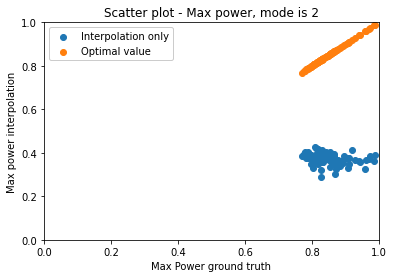

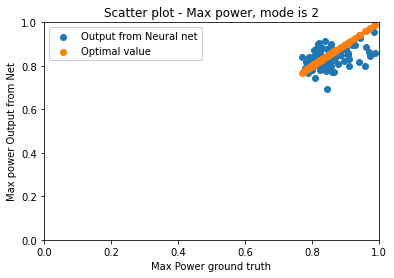

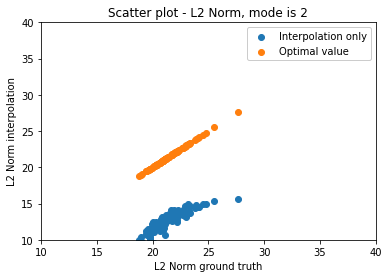

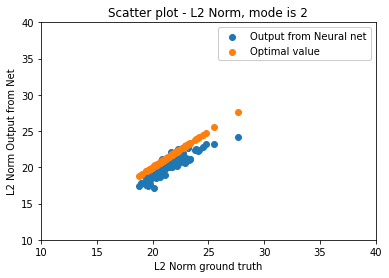

In [23]:
# print(Validation_Ground_Truth[5].shape)
# print(Validation_data[5].shape)
# print(Validation_Ground_Truth.__len__())
# print(Validation_data.__len__())
def Scatter_Plot_Bats(Validation_Ground_Truth,Validation_data):
  with torch.no_grad():
    Max_Power_vect_ground_truth = []
    Max_Power_vect_interp       = []
    Max_Power_vect_net_output   = []

    Norm_vect_ground_truth = []
    Norm_vect_interp       = []
    Norm_vect_net_output   = []
    for i in range(number_of_validation_batches):
      for j in range(Batch_size):
        # print(i)
        # print(Validation_Ground_Truth[i].shape)
        # print(j)
        # print(Validation_Ground_Truth[i][j].shape)
        Max_Power_vect_ground_truth.append(torch.max(Validation_Ground_Truth[i][j]))
        Max_Power_vect_interp.append(torch.max(Validation_data[i][j]))
        Max_Power_vect_net_output.append(torch.max(Bats_net(Validation_data[i])[1][j]))
        Norm_vect_ground_truth.append(torch.norm(Validation_Ground_Truth[i][j]))
        Norm_vect_interp.append(torch.norm(Validation_data[i][j]))
        Norm_vect_net_output.append(torch.norm(Bats_net(Validation_data[i])[1][j]))


    plt.figure()
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_interp,label='Interpolation only')
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('Max power interpolation')
    plt.xlabel('Max Power ground truth')
    plt.title("Scatter plot - Max power, mode is {}".format(mode))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.figure()
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_net_output,label = 'Output from Neural net')
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('Max power Output from Net')
    plt.xlabel('Max Power ground truth')
    plt.title("Scatter plot - Max power, mode is {}".format(mode))
    plt.xlim(0,1)
    plt.ylim(0,1)


    plt.figure()
    plt.scatter(Norm_vect_ground_truth,Norm_vect_interp, label='Interpolation only')
    plt.scatter(Norm_vect_ground_truth,Norm_vect_ground_truth, label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('L2 Norm interpolation')
    plt.xlabel('L2 Norm ground truth')
    plt.title("Scatter plot - L2 Norm, mode is {}".format(mode))
    plt.xlim(10,40)
    plt.ylim(10,40)
    plt.figure()
    plt.scatter(Norm_vect_ground_truth,Norm_vect_net_output,label = 'Output from Neural net')
    plt.scatter(Norm_vect_ground_truth,Norm_vect_ground_truth, label='Optimal value')
    plt.legend(framealpha=1, frameon=True)    
    plt.ylabel('L2 Norm Output from Net')
    plt.xlabel('L2 Norm ground truth')
    plt.title("Scatter plot - L2 Norm, mode is {}".format(mode))
    plt.xlim(10,40)
    plt.ylim(10,40)

# with torch.no_grad():
#   for i in range(number_of_validation_batches):
#     for j in range(Batch_size):
#         Validation_data_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Validation_data[i][j].numpy()))
#         Validation_data_net_output_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Bats_net(Validation_data[i])[1][j].numpy()))
#         Validation_Ground_Truth_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Validation_Ground_Truth[i][j].numpy()))
#     Validation_data_after_filter.append(Validation_data_after_filter_temp.double())
#     Validation_data_net_output_after_filter.append(Validation_data_net_output_after_filter_temp.double())
#     Validation_Ground_Truth_after_filter.append(Validation_Ground_Truth_after_filter_temp.double())


Scatter_Plot_Bats(Validation_Ground_Truth,Validation_data)

In [ ]:
# folder_name = '/content/gdrive/My Drive'

# b= [ str(x.item()) for x in ground_truth[0]]
# a = ','.join(b)
# torch.save(a,"/content/gdrive/My Drive/ground_truth_ex.csv")

# b= [ str(x.item()) for x in output[0]]
# a = ','.join(b)
# torch.save(a,"/content/gdrive/My Drive/Output_from_net_ex.csv")

# b= [ str(x.item()) for x in data2net[idx_signal[0]][0]]
# a = ','.join(b)
# torch.save(a,"/content/gdrive/My Drive/clipped_signal_ex.csv")

Create Band Pass Filter (BPF) on the seocnd chirp, in order to check its power. 

[tensor(3.0936, dtype=torch.float64), tensor(3.2018, dtype=torch.float64), tensor(3.4558, dtype=torch.float64), tensor(3.3511, dtype=torch.float64), tensor(3.4316, dtype=torch.float64), tensor(3.8709, dtype=torch.float64), tensor(3.3467, dtype=torch.float64), tensor(3.2509, dtype=torch.float64), tensor(3.3343, dtype=torch.float64), tensor(2.8138, dtype=torch.float64), tensor(3.3354, dtype=torch.float64), tensor(3.1598, dtype=torch.float64), tensor(3.2820, dtype=torch.float64), tensor(3.7380, dtype=torch.float64), tensor(2.9733, dtype=torch.float64), tensor(3.2171, dtype=torch.float64), tensor(2.9396, dtype=torch.float64), tensor(3.1297, dtype=torch.float64), tensor(3.1148, dtype=torch.float64), tensor(3.4811, dtype=torch.float64), tensor(3.3177, dtype=torch.float64), tensor(3.1127, dtype=torch.float64), tensor(3.0408, dtype=torch.float64), tensor(3.2899, dtype=torch.float64), tensor(3.5550, dtype=torch.float64), tensor(3.4550, dtype=torch.float64), tensor(3.4026, dtype=torch.float64), 

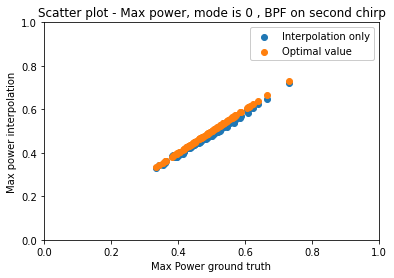

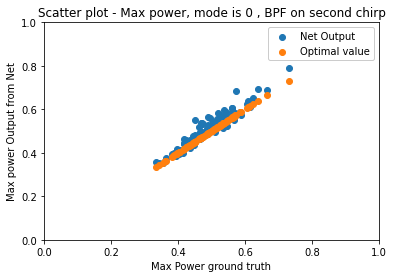

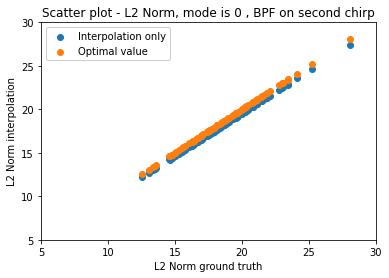

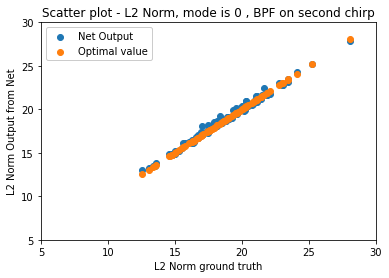

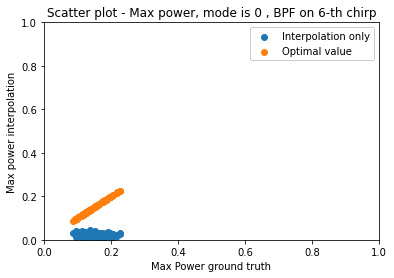

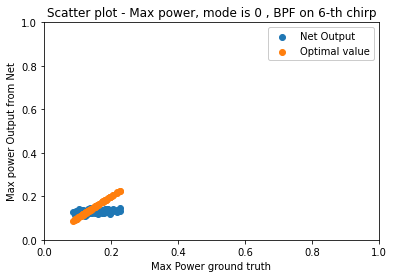

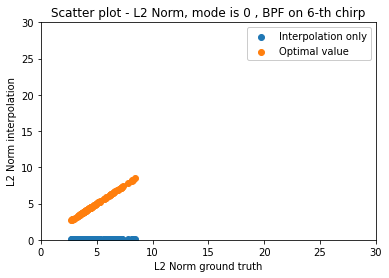

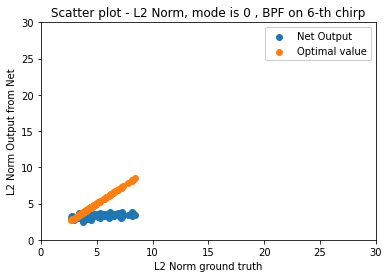

In [11]:
#BPF Generation
from scipy.signal import butter, lfilter
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
########  Second Chirp ######

# Sample rate and desired cutoff frequencies (in Hz).
fs = 250000.0
lowcut = 26000.0
highcut = 30000.0
b, a = butter_bandpass(lowcut, highcut, fs, order=9)#Band Pass Filter for 2-th chirp

Validation_data_after_filter = []
Validation_data_net_output_after_filter = []
Validation_Ground_Truth_after_filter = []
Validation_data_after_filter_temp = torch.zeros(Validation_data[1].shape)
Validation_data_net_output_after_filter_temp = torch.zeros(Validation_data[1].shape)
Validation_Ground_Truth_after_filter_temp = torch.zeros(Validation_Ground_Truth[1].shape)

# Create list of filtered signals
with torch.no_grad():
  for i in range(number_of_validation_batches):
    for j in range(Batch_size):
        Validation_data_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Validation_data[i][j].numpy()))
        Validation_data_net_output_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Bats_net(Validation_data[i])[1][j].numpy()))
        Validation_Ground_Truth_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Validation_Ground_Truth[i][j].numpy()))
    Validation_data_after_filter.append(Validation_data_after_filter_temp.double())
    Validation_data_net_output_after_filter.append(Validation_data_net_output_after_filter_temp.double())
    Validation_Ground_Truth_after_filter.append(Validation_Ground_Truth_after_filter_temp.double())


#Scatter Plot of Power 
with torch.no_grad():
    Max_Power_vect_ground_truth = []
    Max_Power_vect_interp       = []
    Max_Power_vect_net_output   = []

    Norm_vect_ground_truth = []
    Norm_vect_interp       = []
    Norm_vect_net_output   = []
    for i in range(number_of_validation_batches):
      for j in range(Batch_size):
        Max_Power_vect_ground_truth.append(torch.max(Validation_Ground_Truth_after_filter[i][j]))
        Max_Power_vect_interp.append(torch.max(Validation_data_after_filter[i][j]))
        Max_Power_vect_net_output.append(torch.max(Validation_data_net_output_after_filter[i][j]))
        Norm_vect_ground_truth.append(torch.norm(Validation_Ground_Truth_after_filter[i][j]))
        Norm_vect_interp.append(torch.norm(Validation_data_after_filter[i][j]))
        Norm_vect_net_output.append(torch.norm(Validation_data_net_output_after_filter[i][j]))


    plt.figure()
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_interp,label='Interpolation only')
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('Max power interpolation')
    plt.xlabel('Max Power ground truth')
    plt.title("Scatter plot - Max power, mode is {} , BPF on second chirp".format(mode))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.figure()
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_net_output,label='Net Output')
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('Max power Output from Net')
    plt.xlabel('Max Power ground truth')
    plt.title("Scatter plot - Max power, mode is {} , BPF on second chirp".format(mode))
    plt.xlim(0,1)
    plt.ylim(0,1)


    plt.figure()
    plt.scatter(Norm_vect_ground_truth,Norm_vect_interp,label='Interpolation only')
    plt.scatter(Norm_vect_ground_truth,Norm_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('L2 Norm interpolation')
    plt.xlabel('L2 Norm ground truth')
    plt.title("Scatter plot - L2 Norm, mode is {} , BPF on second chirp".format(mode))
    plt.xlim(5,30)
    plt.ylim(5,30)
    plt.figure()
    plt.scatter(Norm_vect_ground_truth,Norm_vect_net_output,label='Net Output')
    plt.scatter(Norm_vect_ground_truth,Norm_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)    
    plt.ylabel('L2 Norm Output from Net')
    plt.xlabel('L2 Norm ground truth')
    plt.title("Scatter plot - L2 Norm, mode is {} , BPF on second chirp".format(mode))
    plt.xlim(5,30)
    plt.ylim(5,30)








############ 6-th chirp #########

fs = 250000.0
lowcut = 80000.0
highcut = 94000.0
b, a = butter_bandpass(lowcut, highcut, fs, order=9)#Band Pass Filter for 6-th chirp

Validation_data_after_filter = []
Validation_data_net_output_after_filter = []
Validation_Ground_Truth_after_filter = []
Validation_data_after_filter_temp = torch.zeros(Validation_data[1].shape)
Validation_data_net_output_after_filter_temp = torch.zeros(Validation_data[1].shape)
Validation_Ground_Truth_after_filter_temp = torch.zeros(Validation_Ground_Truth[1].shape)

# Create list of filtered signals
with torch.no_grad():
  for i in range(number_of_validation_batches):
    for j in range(Batch_size):
        Validation_data_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Validation_data[i][j].numpy()))
        Validation_data_net_output_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Bats_net(Validation_data[i])[1][j].numpy()))
        Validation_Ground_Truth_after_filter_temp[j] = torch.from_numpy(lfilter(b, a, Validation_Ground_Truth[i][j].numpy()))
    Validation_data_after_filter.append(Validation_data_after_filter_temp.double())
    Validation_data_net_output_after_filter.append(Validation_data_net_output_after_filter_temp.double())
    Validation_Ground_Truth_after_filter.append(Validation_Ground_Truth_after_filter_temp.double())


#Scatter Plot of Power 
with torch.no_grad():
    Max_Power_vect_ground_truth = []
    Max_Power_vect_interp       = []
    Max_Power_vect_net_output   = []

    Norm_vect_ground_truth = []
    Norm_vect_interp       = []
    Norm_vect_net_output   = []
    for i in range(number_of_validation_batches):
      for j in range(Batch_size):
        Max_Power_vect_ground_truth.append(torch.max(Validation_Ground_Truth_after_filter[i][j]))
        Max_Power_vect_interp.append(torch.max(Validation_data_after_filter[i][j]))
        Max_Power_vect_net_output.append(torch.max(Validation_data_net_output_after_filter[i][j]))
        Norm_vect_ground_truth.append(torch.norm(Validation_Ground_Truth_after_filter[i][j]))
        Norm_vect_interp.append(torch.norm(Validation_data_after_filter[i][j]))
        Norm_vect_net_output.append(torch.norm(Validation_data_net_output_after_filter[i][j]))


    plt.figure()
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_interp,label='Interpolation only')
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('Max power interpolation')
    plt.xlabel('Max Power ground truth')
    plt.title("Scatter plot - Max power, mode is {} , BPF on 6-th chirp".format(mode))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.figure()
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_net_output,label='Net Output')
    plt.scatter(Max_Power_vect_ground_truth,Max_Power_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('Max power Output from Net')
    plt.xlabel('Max Power ground truth')
    plt.title("Scatter plot - Max power, mode is {} , BPF on 6-th chirp".format(mode))
    plt.xlim(0,1)
    plt.ylim(0,1)


    plt.figure()
    plt.scatter(Norm_vect_ground_truth,Norm_vect_interp,label='Interpolation only')
    plt.scatter(Norm_vect_ground_truth,Norm_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel('L2 Norm interpolation')
    plt.xlabel('L2 Norm ground truth')
    plt.title("Scatter plot - L2 Norm, mode is {} , BPF on 6-th chirp".format(mode))
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.figure()
    plt.scatter(Norm_vect_ground_truth,Norm_vect_net_output,label='Net Output')
    plt.scatter(Norm_vect_ground_truth,Norm_vect_ground_truth,label='Optimal value')
    plt.legend(framealpha=1, frameon=True)    
    plt.ylabel('L2 Norm Output from Net')
    plt.xlabel('L2 Norm ground truth')
    plt.title("Scatter plot - L2 Norm, mode is {} , BPF on 6-th chirp".format(mode))
    plt.xlim(0,30)
    plt.ylim(0,30)

    print(Norm_vect_net_output)